## Single Decision Maker (UNOS) Q-Learning

In [1]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, expon

### Helper functions

In [85]:
# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }
# Ensure state exists in Q-table
def initialize_state_in_q_table(group_Q_tables, group_id, state):

    if state not in group_Q_tables[group_id]:
        group_Q_tables[group_id][state] = [0] * 11  # Initialize all actions with Q-values of 0



### Transition functions

#### Original no people added

In [3]:
# Transition function with shared organ pool management
def decentralized_transition(state, actions, sample_urgency_func):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        for _ in range(patients_per_group[group_id + 1]):  # Iterate over patients in the group
            if new_state["organs"] <= 0:  # Stop if no organs are left
                break
            urgency = sample_urgency_func(group_id)
            if urgency > priority:  # Check if urgency justifies allocation
                matched_organs += 1
                new_state["organs"] -= 1  # Decrement shared organ pool

        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, new_state["organs"])  # Ensure non-negative organ count
    return new_state, rewards

#### People get added

In [92]:
# Transition function with shared organ pool and patient arrivals
def decentralized_transition_add(state, actions, sample_urgency_func, old_patients_per_group):
    patients_per_group = old_patients_per_group.copy()
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    penalties = [0] * num_groups

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        # Iterate over patients currently in the group
        for _ in range(patients_per_group[group_id + 1]):
            if new_state["organs"] <= 0:  # Stop if no organs are left
                break
            urgency = sample_urgency_func(group_id)
            if urgency > priority:  # Check if urgency justifies allocation
                matched_organs += 1
                new_state["organs"] -= 1  # Decrement shared organ pool

        # Add new patients to the group based on Poisson arrivals
        new_patients = np.random.poisson(group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients

        # Update patient group size after matching
        patients_per_group[group_id + 1] -= matched_organs
        new_state["patient_groups"].append({"matched_organs": matched_organs})

        # Reward for matched organs
        
        
        penalties[group_id] = patients_per_group[group_id + 1]
    
    alphas = np.array([0.1, 1, 10])
    for group_id, _ in enumerate(actions):
        rewards[group_id] = matched_organs *actions[group_id] - np.sum(np.array(penalties)*alphas)  # Punish everyone

    # Ensure organs count is non-negative
    new_state["organs"] = max(0, new_state["organs"])

    return new_state, rewards, patients_per_group

In [6]:
def _decentralized_transition_add(state, actions, sample_urgency_func):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups

    # Check if High Risk group (Group 2) has unmatched patients
    high_risk_patients_remaining = patients_per_group[3] > 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        # Iterate over patients currently in the group
        for _ in range(patients_per_group[group_id + 1]):
            if new_state["organs"] <= 0:  # Stop if no organs are left
                break
            urgency = sample_urgency_func(group_id)
            if urgency > priority:  # Check if urgency justifies allocation
                matched_organs += 1
                new_state["organs"] -= 1  # Decrement shared organ pool

        # Add new patients to the group based on Poisson arrivals
        new_patients = np.random.poisson(group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients

        # Update patient group size after matching
        patients_per_group[group_id + 1] -= matched_organs
        new_state["patient_groups"].append({"matched_organs": matched_organs})

        # Reward for matched organs
        base_reward = matched_organs * (10 + group_id)  # Priority-weighted reward

        # Add penalty if High Risk patients are present and allocation goes to other groups
        if high_risk_patients_remaining and group_id != 2:  # Group 2 is High Risk
            penalty = -5 * matched_organs  # Apply a penalty per organ allocated to non-High Risk
            base_reward += penalty

        rewards[group_id] = base_reward

    # Ensure organs count is non-negative
    new_state["organs"] = max(0, new_state["organs"])

    return new_state, rewards


### Sampling distributions

In [72]:
# Define urgency sampling function
def sample_urgency_beta(group_id):
    #Beta params
    alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
    beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

In [73]:
# Sample urgency using Meld
# Define urgency sampling function
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408} #exp

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency_meld(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=3)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=7, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

### Extract optimal policy

In [74]:
# Extract optimal policy
def extract_optimal_policy_Nash(Q_table):
    optimal_policy = {}
    for state, actions in Q_table.items():
        optimal_action = np.argmax(actions)
        optimal_policy[state] = optimal_action
    return optimal_policy


# Simulate with optimal policy
def simulate_with_optimal_policy(optimal_policies, initialize_state, transition_func, sample_func, patients_per_group):
    state = initialize_state()
    organs_allocated_over_time = []
    group_allocations = {group_id: [] for group_id in range(len(optimal_policies))}

    for t in range(time_horizon):
        if state['organs'] <= 0:
            break

        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            key = (state["time"], state["organs"])
            if key in optimal_policy:
                actions.append(optimal_policy[key])
            else:
                print("using random action")
                actions.append(random.choice(range(11)))

        next_state, _, patients_per_group = transition_func(state, actions, sample_func, patients_per_group)
        cumulative_allocations = total_organs - next_state["organs"]
        organs_allocated_over_time.append(cumulative_allocations)

        for group_id, group_info in enumerate(next_state["patient_groups"]):
            group_allocations[group_id].append(group_info["matched_organs"])

        state = next_state

    return organs_allocated_over_time, group_allocations

### Q-learning loop

In [75]:
def Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon): 
    # Initialize Q-tables for each group
    group_Q_tables = [
        {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
        for _ in range(num_groups)
    ]

    # Q-learning loop
    group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

    for episode in range(num_episodes):
        state = initialize_state()
        total_rewards = [0] * num_groups

        for t in range(time_horizon):
            if state["organs"] <= 0:
                break

            # Compute Nash equilibrium actions
            actions = []
            for group_id in range(num_groups):
                group_state = (state["time"], state["organs"])
                if random.uniform(0, 1) < epsilon:
                    actions.append(random.randint(0, 10))  # Explore
                else:
                    actions.append(np.argmax(group_Q_tables[group_id][group_state]))  # Exploit

            # Perform decentralized transition
            next_state, rewards, patients_per_group = transition_func(state, actions, sample_func, patients_per_group)

            # Update Q-tables
            for group_id in range(num_groups):
                group_state = (state["time"], state["organs"])
                next_group_state = (next_state["time"], next_state["organs"])
                initialize_state_in_q_table(group_Q_tables, group_id, group_state)
                initialize_state_in_q_table(group_Q_tables, group_id, next_group_state)
                best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
                q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
                group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                    q_update - group_Q_tables[group_id][group_state][actions[group_id]]
                )

            state = next_state
            total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

        for group_id in range(num_groups):
            group_rewards_per_episode[group_id].append(total_rewards[group_id])

        epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon
    return group_Q_tables, group_rewards_per_episode


### Plots

In [90]:
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']

def plot_cumulative(group_rewards_per_episode, title):
    # Plot cumulative rewards per episode
    plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
    plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
    plt.title("Cumulative Rewards per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.legend(title="Group")
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    #plt.savefig(f"{title}.png")
    plt.show()

def plot_average(group_rewards_per_episode, title):
    window = 20  # Moving average window
    avg_rewards = [ [
        np.mean(group_rewards_per_episode[group_id][i : i + window])
        for i in range(len(group_rewards_per_episode[group_id]) - window)
    ] for group_id in range(num_groups)]

    # Plot cumulative rewards per episode
    labels = ['Low Risk', 'Medium Risk', 'High Risk']
    colors = ['green', 'orange', 'red']
    plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
    for group_id in range(num_groups):
        plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
    plt.title("Average Rewards per Episode for Each Group")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(title="Group")
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    #plt.savefig(f"{title}.png")
    plt.show()

def plot_organs_allocated(group_Q_tables, transition_func, sample_func, title, patients_per_group):
    # Simulate and plot results
    optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]
    organs_allocated_over_time, group_allocations = simulate_with_optimal_policy(
        optimal_policies, initialize_state, transition_func, sample_func, patients_per_group
    )

    plt.plot(organs_allocated_over_time, label="Total Allocations")
    for group_id, allocations in group_allocations.items():
        plt.plot(np.cumsum(allocations), label=labels[group_id], color = colors[group_id])
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)


    # Format the plot
    plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')

    plt.xlim(0)
    plt.ylim(0)
    plt.title("Organs Allocated Over Time for Each Group")
    plt.xlabel("Time Steps")
    plt.ylabel("Total Organs Allocated")
    plt.legend()
    #plt.savefig(f"{title}.png")

    plt.show()

### Test area

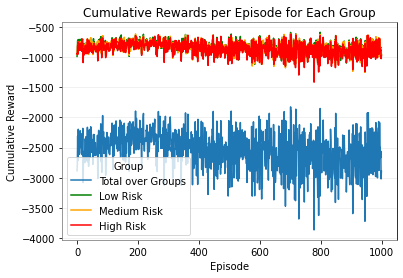

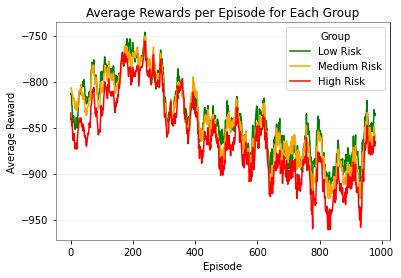

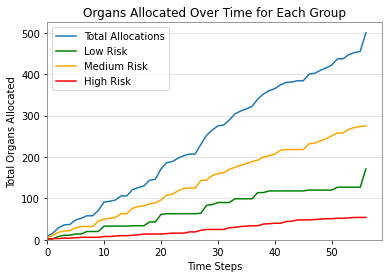

In [93]:


# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 100  # Ischemic time limit (discrete time steps)
num_episodes = 1000  # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3: 1}
group_lambdas = [3, 5, 1]  # Mean number of new patients for each group

epsilon = 0.8
alpha = 0.9
gamma = 1

transition_func = decentralized_transition_add
sample_func = sample_urgency_beta




group_Q_tables, group_rewards_per_episode = Nash_Q_learn(transition_func, sample_func, patients_per_group, num_episodes, alpha, gamma, epsilon)
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]
patients_per_group = {1: 2, 2: 5, 3: 1}
organs_allocated_over_time, group_allocations = simulate_with_optimal_policy(
        optimal_policies, initialize_state, transition_func, sample_func, patients_per_group
    )

plot_cumulative(group_rewards_per_episode, "x")
plot_average(group_rewards_per_episode, "x")
patients_per_group = {1: 2, 2: 5, 3: 1}
plot_organs_allocated(group_Q_tables, transition_func, sample_func, "x", patients_per_group)

In [94]:
group_Q_tables

[{(0, 0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 1): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 2): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 3): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 4): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 5): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 6): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 7): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 8): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 9): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 10): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 11): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 12): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 13): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 14): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 15): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 16): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 17): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 18): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 19): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 20): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  (0, 21): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

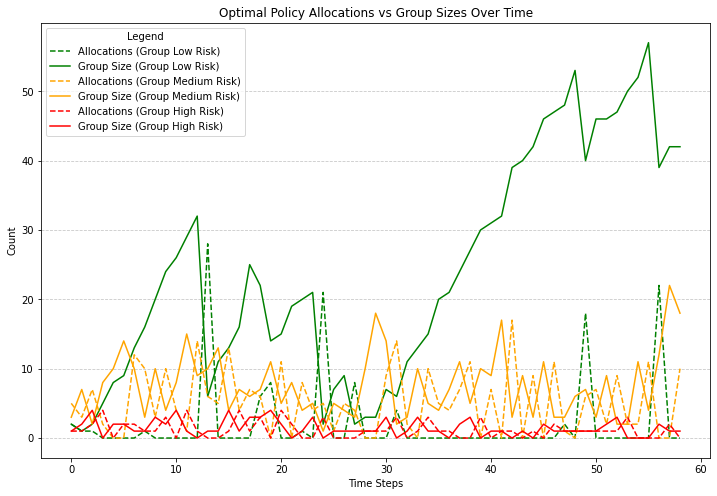

In [95]:
def simulate_optimal_policy_and_track(optimal_policies, total_organs, time_horizon, initialize_state, transition_func,
                                     sample_frequency_func):
    """
    Simulates the allocation process under the optimal policy and tracks the allocations
    and group sizes over time.

    Parameters:
        optimal_policies (list): Optimal policies for each group.
        total_organs (int): Total number of available organs.
        time_horizon (int): Maximum time steps for simulation.
        initialize_state (function): Function to initialize the state.
        transition_func (function): Transition function for updating the state.

    Returns:
        results (dict): Dictionary containing time series of allocations and group sizes for each group.
    """
    state = initialize_state()
    patients_per_group = {1: 2, 2: 5, 3: 1}
    results = {group_id: {"allocations": [], "group_sizes": []} for group_id in range(num_groups)}

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute actions based on optimal policy
        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            group_state = (state["time"], state["organs"])
            if group_state in optimal_policy:
                actions.append(optimal_policy[group_state])
            else:
                actions.append(0)  # Default action if state not in policy

        # Perform the transition
        next_state, _ , patients_per_group = transition_func(state, actions, sample_frequency_func, patients_per_group)

        # Track allocations and group sizes for each group
        for group_id, group_info in enumerate(next_state["patient_groups"]):
            allocations = group_info["matched_organs"]
            group_size = patients_per_group[group_id + 1]
            results[group_id]["allocations"].append(allocations)
            results[group_id]["group_sizes"].append(group_size)

        state = next_state

    return results


# Extract optimal policies for each group
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]

# Simulate and track results
results = simulate_optimal_policy_and_track(
    optimal_policies, total_organs, time_horizon, initialize_state, decentralized_transition_add, sample_urgency_beta
)

# Plot results
plt.figure(figsize=(12, 8))
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']

for group_id in range(num_groups):
    # Plot allocations
    plt.plot(
        range(len(results[group_id]["allocations"])),
        results[group_id]["allocations"],
        label=f"Allocations (Group {labels[group_id]})",
        linestyle="--",
        color=colors[group_id]
    )

    # Plot group sizes
    plt.plot(
        range(len(results[group_id]["group_sizes"])),
        results[group_id]["group_sizes"],
        label=f"Group Size (Group {labels[group_id]})",
        color=colors[group_id]
    )

plt.title("Optimal Policy Allocations vs Group Sizes Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend(title="Legend", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


first patients per group {1: 2, 2: 5, 3: 1}
first patients per group {1: 2, 2: 5, 3: 1}
first patients per group {1: 2, 2: 4, 3: 1}
first patients per group {1: 9, 2: 8, 3: 0}
first patients per group {1: 16, 2: 8, 3: 0}
first patients per group {1: 16, 2: 8, 3: 0}
first patients per group {1: 21, 2: 10, 3: 3}
first patients per group {1: 5, 2: 10, 3: 3}
first patients per group {1: 5, 2: 0, 3: 3}
first patients per group {1: 7, 2: 6, 3: 2}
first patients per group {1: 0, 2: 6, 3: 2}
first patients per group {1: 0, 2: 7, 3: 2}
first patients per group {1: 1, 2: 11, 3: 3}
first patients per group {1: 2, 2: 11, 3: 3}
first patients per group {1: 2, 2: 2, 3: 3}
first patients per group {1: 3, 2: 9, 3: 3}
first patients per group {1: 1, 2: 9, 3: 3}
first patients per group {1: 1, 2: 4, 3: 3}
first patients per group {1: 3, 2: 6, 3: 3}
first patients per group {1: 3, 2: 6, 3: 3}
first patients per group {1: 3, 2: 7, 3: 3}
first patients per group {1: 6, 2: 11, 3: 0}
first patients per group

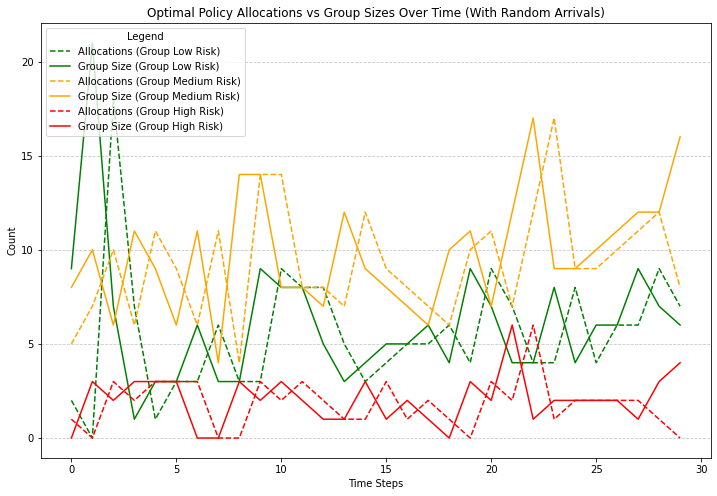

In [70]:
def simulate_policy_with_random_arrivals(optimal_policies, initialize_state, transition_func, sample_func, arrival_func):
    """
    Simulates the allocation process under the optimal policy with random patient arrivals.
    Tracks allocations and group sizes for each group at each time step.

    Parameters:
        optimal_policies (list): Optimal policies for each group.
        initialize_state (function): Function to initialize the state.
        transition_func (function): Transition function to simulate state transitions.
        sample_func (function): Function to sample urgency or other parameters.
        arrival_func (function): Function to randomly add patients to groups.

    Returns:
        results (dict): Dictionary containing time series of allocations and group sizes for each group.
    """
    state = initialize_state()
    patients_per_group = {1: 2, 2: 5, 3: 1}
    results = {group_id: {"allocations": [], "group_sizes": []} for group_id in range(len(optimal_policies))}

    for t in range(time_horizon):
        if state["organs"] <= 0:  # Stop if no organs are left
            break

        # Compute actions based on optimal policies
        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            key = (state["time"], state["organs"])
            if key in optimal_policy:
                actions.append(optimal_policy[key])
            else:
                actions.append(0)  # Default action if state is not in the policy

        # Perform the transition
        next_state, _ , patients_per_group = transition_func(state, actions, sample_func, patients_per_group)

        # Add new patients to each group randomly using the arrival_func
        for group_id in range(num_groups):
            new_patients = arrival_func(group_id)  # Random number of new patients
            patients_per_group[group_id + 1] += new_patients  # Update group sizes

        # Track allocations and group sizes for each group
        for group_id, group_info in enumerate(next_state["patient_groups"]):
            allocations = group_info["matched_organs"]
            group_size = patients_per_group[group_id + 1]  # Current size of the group after arrivals
            results[group_id]["allocations"].append(allocations)
            results[group_id]["group_sizes"].append(group_size)

        # Update the state
        state = next_state

    return results


# Define a random patient arrival function
def random_patient_arrival(group_id):
    """
    Generates a random number of new patients for a given group.
    For example, Poisson distributed arrivals.
    """
    return np.random.poisson(group_lambdas[group_id])


# Extract optimal policies for all groups
optimal_policies = [extract_optimal_policy_Nash(Q_table) for Q_table in group_Q_tables]

# Simulate and track results
results = simulate_policy_with_random_arrivals(
    optimal_policies, initialize_state, decentralized_transition_add, sample_urgency_beta, random_patient_arrival
)

# Plot results
plt.figure(figsize=(12, 8))
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']

for group_id in range(num_groups):
    # Plot allocations
    plt.plot(
        range(len(results[group_id]["allocations"])),
        results[group_id]["allocations"],
        label=f"Allocations (Group {labels[group_id]})",
        linestyle="--",
        color=colors[group_id]
    )

    # Plot group sizes
    plt.plot(
        range(len(results[group_id]["group_sizes"])),
        results[group_id]["group_sizes"],
        label=f"Group Size (Group {labels[group_id]})",
        color=colors[group_id]
    )

plt.title("Optimal Policy Allocations vs Group Sizes Over Time (With Random Arrivals)")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend(title="Legend", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


[{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 0, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): 0, (0, 13): 0, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): 0, (0, 18): 0, (0, 19): 0, (0, 20): 0, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): 0, (0, 25): 0, (0, 26): 0, (0, 27): 0, (0, 28): 0, (0, 29): 0, (0, 30): 0, (0, 31): 0, (0, 32): 0, (0, 33): 0, (0, 34): 0, (0, 35): 0, (0, 36): 0, (0, 37): 0, (0, 38): 0, (0, 39): 0, (0, 40): 0, (0, 41): 0, (0, 42): 0, (0, 43): 0, (0, 44): 0, (0, 45): 0, (0, 46): 0, (0, 47): 0, (0, 48): 0, (0, 49): 0, (0, 50): 0, (0, 51): 0, (0, 52): 0, (0, 53): 0, (0, 54): 0, (0, 55): 0, (0, 56): 0, (0, 57): 0, (0, 58): 0, (0, 59): 0, (0, 60): 0, (0, 61): 0, (0, 62): 0, (0, 63): 0, (0, 64): 0, (0, 65): 0, (0, 66): 0, (0, 67): 0, (0, 68): 0, (0, 69): 0, (0, 70): 0, (0, 71): 0, (0, 72): 0, (0, 73): 0, (0, 74): 0, (0, 75): 0, (0, 76): 0, (0, 77): 0, (0, 78): 0, (0, 79): 0, (0, 80): 0, (0, 81): 0, (0, 82): 0, (0, 83): 0, 

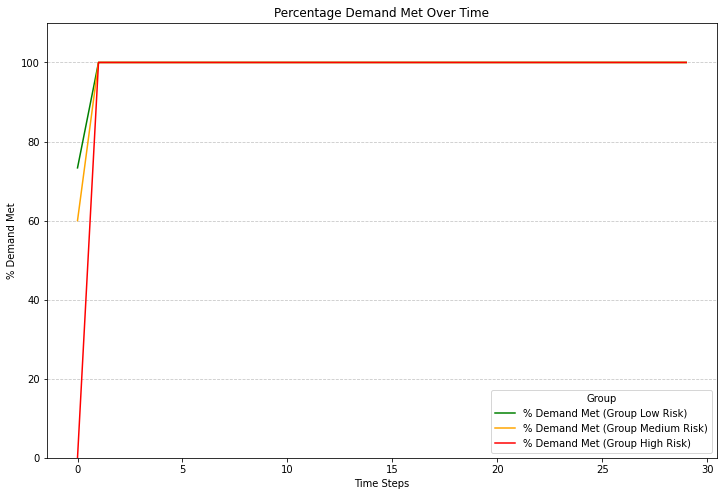

In [79]:
def simulate_policy_with_demand_analysis(optimal_policies, initialize_state, transition_func, sample_func, arrival_func):
    """
    Simulates the allocation process under the optimal policy with random patient arrivals.
    Tracks allocations, group sizes, and % demand met for each group at each time step.

    Parameters:
        optimal_policies (list): Optimal policies for each group.
        initialize_state (function): Function to initialize the state.
        transition_func (function): Transition function to simulate state transitions.
        sample_func (function): Function to sample urgency or other parameters.
        arrival_func (function): Function to randomly add patients to groups.

    Returns:
        results (dict): Dictionary containing allocations, group sizes, and % demand met for each group.
    """
    state = initialize_state()
    old_patients_per_group = {1: 30, 2: 60, 3: 24}
    results = {group_id: {"allocations": [], "group_sizes": [], "percent_demand_met": []} for group_id in range(len(optimal_policies))}

    
    print(optimal_policies)
    for t in range(time_horizon):
        if state["organs"] <= 0:  # Stop if no organs are left
            break

        # Compute actions based on optimal policies
        actions = []
        for group_id, optimal_policy in enumerate(optimal_policies):
            key = (state["time"], state["organs"])
            if key in optimal_policy:
                actions.append(optimal_policy[key])
            else:
                print("Using random policy")
                actions.append(0)  # Default action if state is not in the policy

        # Perform the transition
        next_state, _, patients_per_group = transition_func(state, actions, sample_func, old_patients_per_group)
        # this already takes care of the adding and subtracting patients 
        print("Next state: ", next_state)
        print(old_patients_per_group)
        

        # Track allocations, group sizes, and % demand met for each group
        for group_id, group_info in enumerate(next_state["patient_groups"]):
            allocations = group_info["matched_organs"]
            group_size = old_patients_per_group[group_id + 1]  # Current size of the group after arrivals

            # Calculate % demand met
            percent_demand_met = (allocations / group_size) * 100 if group_size > 0 else 100

            results[group_id]["allocations"].append(allocations)
            results[group_id]["group_sizes"].append(group_size)
            results[group_id]["percent_demand_met"].append(percent_demand_met)
            

        # Update the state
        state = next_state
        old_patients_per_group = patients_per_group

    return results


# Simulate and track results
results_with_demand = simulate_policy_with_demand_analysis(
    optimal_policies, initialize_state, decentralized_transition_add, sample_urgency_beta, random_patient_arrival
)

# Plot results: % Demand Met
plt.figure(figsize=(12, 8))
labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Total']
colors = ['green', 'orange', 'red', 'blue']

for group_id in range(num_groups):
    # Plot % demand met
    plt.plot(
        range(len(results_with_demand[group_id]["percent_demand_met"])),
        results_with_demand[group_id]["percent_demand_met"],
        label=f"% Demand Met (Group {labels[group_id]})",
        color=colors[group_id]
    )

plt.title("Percentage Demand Met Over Time")
plt.xlabel("Time Steps")
plt.ylabel("% Demand Met")
plt.legend(title="Group")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 110)  # Limit y-axis to 100% (or slightly above for visualization)
plt.show()
